# CSE 144 Spring 2023 Assignment 2
For this assignment, your task is to train a several convolutional neural networks to classify CIFAR-10 images. CIFAR-10 is a 10-class image classification dataset with 50,000 training images and 10,000 test images. You can find more info in https://www.cs.toronto.edu/~kriz/cifar.html. You should define a simple CNN with restrictions to classify this dataset. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import random
import torch
from torch import nn, optim
import math
from IPython import display
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import pdb

#### Step-0: Setting a Seed for Random Number Generators in Python and PyTorch

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

#### Step-1: Import dataset
Load the CIFAR-10 dataset using `datasets.CIFAR10` and use 10% of training images as validation data. Notice that PyTorch would normalize the range of pixel values to 0-1 automatically. (5 scores)

In [3]:
# ###### Your codes start here.######
# Loading the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()]))
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Split the training set into train and validation sets
val_dataset_size = int(len(train_dataset) * 0.1)
train_dataset_size = len(train_dataset) - val_dataset_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_dataset_size, val_dataset_size])
# ###### Your codes end here.######

Files already downloaded and verified
Files already downloaded and verified


#### Step-2: Building Data Loaders

In this step, you will use PyTorch's DataLoader function to create data loaders for your training, validation, and test datasets. The DataLoader function allows you to load data in batches, which can help improve training efficiency. You will set the batch size to 128, which means that the model will be trained on 128 samples at a time.

For the train_dataset, you will set the shuffle parameter to True, which randomizes the order in which the data is loaded, helping the model learn from a more diverse set of examples. On the other hand, for the val_dataset and test_dataset, you will set the shuffle parameter to False. (5 scores)

In [4]:
###### Your codes start here.######
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
###### Your codes end here.######

# assert the size of the train dataset
assert len(train_dataset) == 45000
assert train_dataset[0][0].shape == torch.Size([3, 32, 32])

# assert the size of the validation dataset
assert len(val_dataset) == 5000
assert val_dataset[0][0].shape == torch.Size([3, 32, 32])

# assert the size of the test dataset
assert len(test_dataset) == 10000
assert test_dataset[0][0].shape == torch.Size([3, 32, 32])

**Visulize one image from CIFAR**

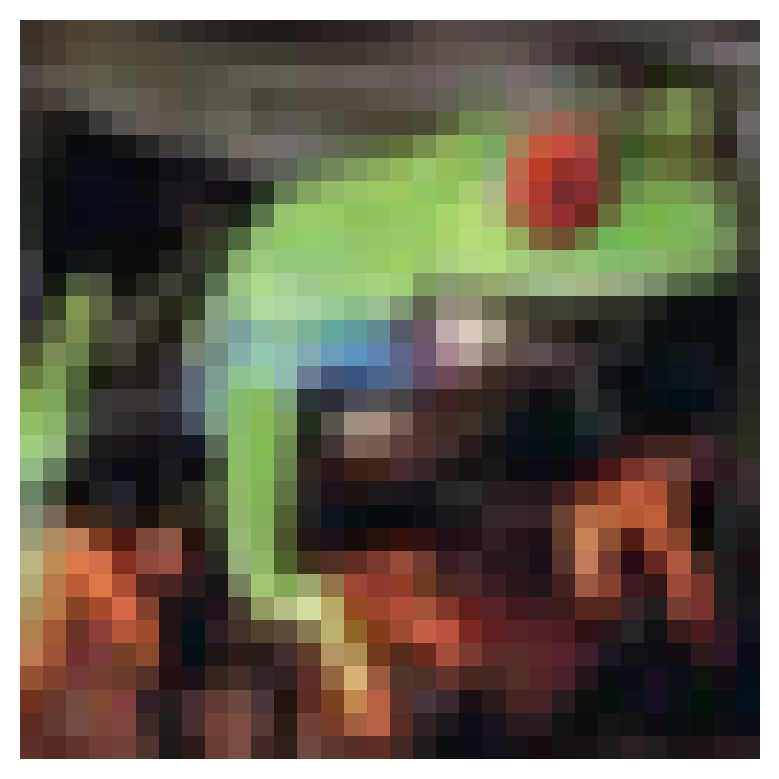

In [5]:
image, _ = trainloader.dataset.__getitem__(0)
image = image.permute(1,2,0)
plt.imshow(image, cmap=plt.cm.binary)
plt.axis('off');

#### Step-3: Build a neural network.
Build your convolutional neural networks by adding some layers. You should use 2 convolution layers and ReLU as the default activation function. The kernel size of both layers should be 3x3. Use 32 and 64 as the number of filters for the first and the second convolutional layers, respectively. After that, flatten your input and add two more dense layers. There should be 1024 units in the first dense with ReLU activation, and use 10 hidden units in the second dense layer with softmax activation. The requirements are same for the following questions. (10 scores)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
###### Your code starts here. ######
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*6*6, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64*6*6)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x
###### Your codes end here.######

#### Step-4: Train the model
Compile model here and set your initial hyperparameters. Use SGD as the optimizer with initial learning rate 0.01. You could choose 'CrossEntropyLoss' as your loss function, and the metrics should be accuracy. After that, train your model for 10 epochs. The requirements are same for the following questions. (15 scores)

In [8]:
def evaluate_model(model, dataloader, is_test=False):
  #Evaluation

  # Set model to evaluation mode
  model.eval()

  with torch.no_grad():
    correct = 0
    loss = 0

    criterion = torch.nn.CrossEntropyLoss(reduction='none')

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        
        loss += torch.sum(criterion(outputs, target)).item()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        "Test" if is_test else "Validation",
        loss, correct, len(dataloader.dataset),
        accuracy))
  # Set model back to training mode
  model.train()

###### Your code starts here. ######
def train_model(model, epochs, trainloader, valloader, optimizer):
    model.train()

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        evaluate_model(model, valloader)
###### Your code end here. ######

**Set hyper-parameters**

In [9]:
learning_rate = 0.01
epochs = 10
batch_size = 128

In [10]:
model_step_3 = Model_3()
model_step_3.to(device)
  
optimizer = torch.optim.SGD(model_step_3.parameters(), lr=learning_rate)
train_model(model_step_3, epochs, trainloader, valloader, optimizer)


Validation set: Average loss: 2.2826, Accuracy: 1027/5000 (21%)


Validation set: Average loss: 2.1499, Accuracy: 1354/5000 (27%)


Validation set: Average loss: 1.9719, Accuracy: 1398/5000 (28%)


Validation set: Average loss: 1.9103, Accuracy: 1543/5000 (31%)


Validation set: Average loss: 1.8214, Accuracy: 1803/5000 (36%)


Validation set: Average loss: 1.7397, Accuracy: 1894/5000 (38%)


Validation set: Average loss: 1.7189, Accuracy: 1954/5000 (39%)


Validation set: Average loss: 1.6651, Accuracy: 2064/5000 (41%)


Validation set: Average loss: 1.5757, Accuracy: 2187/5000 (44%)


Validation set: Average loss: 1.4965, Accuracy: 2322/5000 (46%)



In [11]:
# Evaluation
evaluate_model(model_step_3, testloader, is_test=True)


Test set: Average loss: 1.4784, Accuracy: 4757/10000 (48%)



#### Step-5: Regularization
Add one dropout layer with 0.5 drop rate between the two dense layer and apply a SGD with momentum 0.9. You can keep all other hyperparameters the same. (5 scores)

In [12]:
###### Your code starts here. ######
class Model_5(nn.Module):
    def __init__(self):
        super(Model_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*6*6, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64*6*6)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model_step_5 = Model_5()
model_step_5.to(device)
  
optimizer = torch.optim.SGD(model_step_5.parameters(), lr=learning_rate, momentum=0.9)
train_model(model_step_5, epochs, trainloader, valloader, optimizer)
###### Your codes end here.######


Validation set: Average loss: 1.7820, Accuracy: 1829/5000 (37%)


Validation set: Average loss: 1.4918, Accuracy: 2276/5000 (46%)


Validation set: Average loss: 1.3169, Accuracy: 2630/5000 (53%)


Validation set: Average loss: 1.2059, Accuracy: 2880/5000 (58%)


Validation set: Average loss: 1.1080, Accuracy: 3039/5000 (61%)


Validation set: Average loss: 1.0394, Accuracy: 3197/5000 (64%)


Validation set: Average loss: 0.9978, Accuracy: 3266/5000 (65%)


Validation set: Average loss: 0.9638, Accuracy: 3313/5000 (66%)


Validation set: Average loss: 0.8949, Accuracy: 3423/5000 (68%)


Validation set: Average loss: 0.8594, Accuracy: 3493/5000 (70%)



In [13]:
# Evaluation
evaluate_model(model_step_5, testloader, is_test=True)


Test set: Average loss: 0.8641, Accuracy: 7005/10000 (70%)



#### Step-6: Deeper neural network

Try to add two more convolution layers in your model (four in total). Use 128 as the number of filters for two extra convolution layers, and 3x3 as the kernel size. (5 scores)

In [14]:
###### Your code starts here. ######
class Model_6(nn.Module):
    def __init__(self):
        super(Model_6, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.fc1 = nn.Linear(128*2*2, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = x.view(-1, 128*2*2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model_step_6 = Model_6()
model_step_6.to(device)
  
optimizer = torch.optim.SGD(model_step_6.parameters(), lr=learning_rate, momentum=0.9)
train_model(model_step_6, epochs, trainloader, valloader, optimizer)
###### Your codes end here.######


Validation set: Average loss: 2.1336, Accuracy: 1023/5000 (20%)


Validation set: Average loss: 1.7189, Accuracy: 1762/5000 (35%)


Validation set: Average loss: 1.5610, Accuracy: 2108/5000 (42%)


Validation set: Average loss: 1.3900, Accuracy: 2369/5000 (47%)


Validation set: Average loss: 1.2457, Accuracy: 2759/5000 (55%)


Validation set: Average loss: 1.1326, Accuracy: 2955/5000 (59%)


Validation set: Average loss: 1.1061, Accuracy: 3033/5000 (61%)


Validation set: Average loss: 0.9956, Accuracy: 3229/5000 (65%)


Validation set: Average loss: 0.9440, Accuracy: 3320/5000 (66%)


Validation set: Average loss: 0.8951, Accuracy: 3416/5000 (68%)



In [15]:
# Evaluation
evaluate_model(model_step_6, testloader, is_test=True)


Test set: Average loss: 0.8944, Accuracy: 6879/10000 (69%)



#### Step-7: Activation function

Try another activation function, such as elu, P-ReLU. (5 scores)

In [16]:
###### Your code starts here. ######
class Model_7(nn.Module):
    def __init__(self):
        super(Model_7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.fc1 = nn.Linear(128*2*2, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = nn.functional.elu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = nn.functional.elu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = nn.functional.elu(x)
        x = self.conv4(x)
        x = nn.functional.elu(x)
        x = x.view(-1, 128*2*2)
        x = self.fc1(x)
        x = nn.functional.elu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model_step_7 = Model_7()
model_step_7.to(device)
  
optimizer = torch.optim.SGD(model_step_7.parameters(), lr=learning_rate, momentum=0.9)
train_model(model_step_7, epochs, trainloader, valloader, optimizer)
###### Your codes end here.######


Validation set: Average loss: 1.7084, Accuracy: 1863/5000 (37%)


Validation set: Average loss: 1.4347, Accuracy: 2372/5000 (47%)


Validation set: Average loss: 1.3222, Accuracy: 2652/5000 (53%)


Validation set: Average loss: 1.2265, Accuracy: 2801/5000 (56%)


Validation set: Average loss: 1.1140, Accuracy: 3026/5000 (61%)


Validation set: Average loss: 1.0463, Accuracy: 3151/5000 (63%)


Validation set: Average loss: 1.0001, Accuracy: 3266/5000 (65%)


Validation set: Average loss: 0.9551, Accuracy: 3340/5000 (67%)


Validation set: Average loss: 0.9136, Accuracy: 3414/5000 (68%)


Validation set: Average loss: 0.8814, Accuracy: 3460/5000 (69%)



In [17]:
# Evaluation
evaluate_model(model_step_7, testloader, is_test=True)


Test set: Average loss: 0.8761, Accuracy: 6933/10000 (69%)

